In [6]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import scipy.stats as st
import os
import numpy as np
import random
from scipy.stats import linregress
from scipy.stats import pearsonr
import hvplot.pandas
import requests

In [7]:
movie_df = pd.read_csv('movies_awards.csv')
movie_df.shape

(5453, 21)

In [8]:
movie_df_copy = movie_df.copy()

In [9]:
filter_criteria = (
    (movie_df_copy['Metascore'].notna()) &
    (movie_df_copy['Box Office'].notna()) &
    (movie_df_copy['Oscar Nominations'].notna()) & 
    #(movie_df_copy['Rotten Tomatoes Rating'].notna()) & 
    (movie_df_copy['Metascore'] != 'Rating not found') &  
    #(movie_df_copy['Rotten Tomatoes Rating'] != 'Rating not found') &  
    (movie_df_copy['Box Office'] != 'Box Office not found')
)
clean_movie_df = movie_df_copy[filter_criteria]
clean_movie_df.shape


(71, 21)

In [10]:
clean_movie_df2 = clean_movie_df.copy()

In [11]:
#clean_movie_df2['Rotten Tomatoes Rating'] = pd.to_numeric(clean_movie_df2['Rotten Tomatoes Rating'], errors='coerce')
clean_movie_df2['IMDb Rating'] = pd.to_numeric(clean_movie_df2['IMDb Rating'], errors='coerce')
clean_movie_df2['Metascore'] = pd.to_numeric(clean_movie_df2['Metascore'], errors='coerce')
print(clean_movie_df2.dtypes)

Movie_Title                object
Year                        int64
Director                   object
Actors                     object
Rating                    float64
Runtime(Mins)               int64
Censor                     object
Total_Gross                object
main_genre                 object
side_genre                 object
Movie Rated                object
Language                   object
Rotten Tomatoes Rating    float64
IMDb Rating               float64
Metascore                 float64
Box Office                 object
imdbID                     object
Oscar Awards              float64
Oscar Nominations         float64
Award Wins                float64
Award Nominations         float64
dtype: object


In [12]:
# Convert 'Box Office' to numeric after removing $ and commas
clean_movie_df2['Box Office'] = clean_movie_df2['Box Office'].replace('[\$,]', '', regex=True).astype(int)

# Convert millions to a more readable format
clean_movie_df2['Box Office (in M)'] = (clean_movie_df2['Box Office'] / 1e6).round(1).astype(str) + 'M'

clean_movie_df2.head(5)

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,...,Rotten Tomatoes Rating,IMDb Rating,Metascore,Box Office,imdbID,Oscar Awards,Oscar Nominations,Award Wins,Award Nominations,Box Office (in M)
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama",...,0.94,9.0,84.0,534987076,tt0468569,2.0,8.0,163.0,164.0,535.0M
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama",...,0.94,9.0,94.0,379427292,tt0167260,11.0,11.0,215.0,124.0,379.4M
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi",...,0.87,8.8,74.0,292587330,tt1375666,4.0,8.0,159.0,220.0,292.6M
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama",...,0.95,8.8,87.0,342952511,tt0167261,2.0,6.0,132.0,138.0,343.0M
5,The Lord of the Rings: The Fellowship of the Ring,2001,Peter Jackson,"Elijah Wood, Ian McKellen, Orlando Bloom, Sean...",8.8,178,U,$315.54M,Action,"Adventure, Drama",...,0.91,8.9,92.0,316115420,tt0120737,4.0,13.0,125.0,127.0,316.1M


In [13]:
bins = [0, 100000000, 200000000, 300000000, 400000000, 500000000, 1000000000]
labels = ['0 - $100M', '100M - $200M', '200M - $300M', '300M - $400M', '$400M - $500M', 'Over $500M']
clean_movie_df2['Box Office Category'] = pd.cut(clean_movie_df2['Box Office'], bins, labels=labels, right=True, include_lowest=True)

In [14]:
clean_movie_df2.head(20)
clean_movie_df2.columns

Index(['Movie_Title', 'Year', 'Director', 'Actors', 'Rating', 'Runtime(Mins)',
       'Censor', 'Total_Gross', 'main_genre', 'side_genre', 'Movie Rated',
       'Language', 'Rotten Tomatoes Rating', 'IMDb Rating', 'Metascore',
       'Box Office', 'imdbID', 'Oscar Awards', 'Oscar Nominations',
       'Award Wins', 'Award Nominations', 'Box Office (in M)',
       'Box Office Category'],
      dtype='object')

In [15]:
# Groupby Checks
grouped = clean_movie_df2.groupby('Oscar Nominations')[['Rotten Tomatoes Rating', 'IMDb Rating', 'Metascore']].mean()
grouped.head(15)

,Rotten Tomatoes Rating,IMDb Rating,Metascore
Oscar Nominations,,,
1.0,0.779167,7.358333,67.750000
2.0,0.772222,7.177778,64.111111
3.0,0.863636,7.645455,72.363636
4.0,0.817000,7.790000,77.000000
5.0,0.806667,7.666667,75.000000
6.0,0.836000,7.900000,74.600000
7.0,0.952500,7.825000,84.500000
8.0,0.871429,7.971429,81.428571
9.0,0.820000,7.900000,83.000000


In [16]:
# Groupby Checks
grouped = clean_movie_df2.groupby('Box Office Category')['Movie_Title'].count()
grouped.head(6)

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_14378/3180518641.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = clean_movie_df2.groupby('Box Office Category')['Movie_Title'].count()


Box Office Category
0 - $100M        24
100M - $200M     21
200M - $300M     12
300M - $400M      7
$400M - $500M     3
Over $500M        4
Name: Movie_Title, dtype: int64

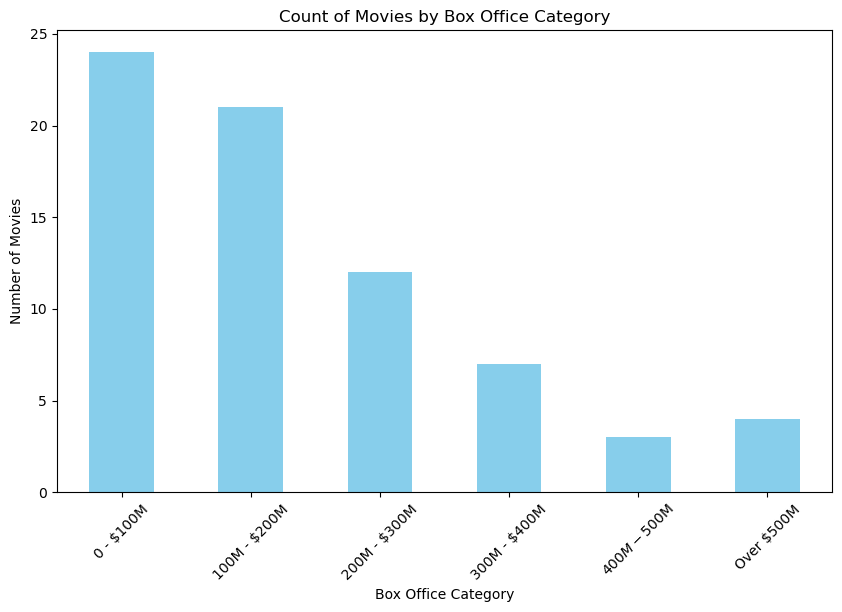

In [17]:
# Bar Graph
grouped.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Titles and labels
plt.title('Count of Movies by Box Office Category')
plt.xlabel('Box Office Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_14378/2444825392.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = clean_movie_df2.groupby('Box Office Category')['Oscar Awards'].agg(['sum', 'mean'])


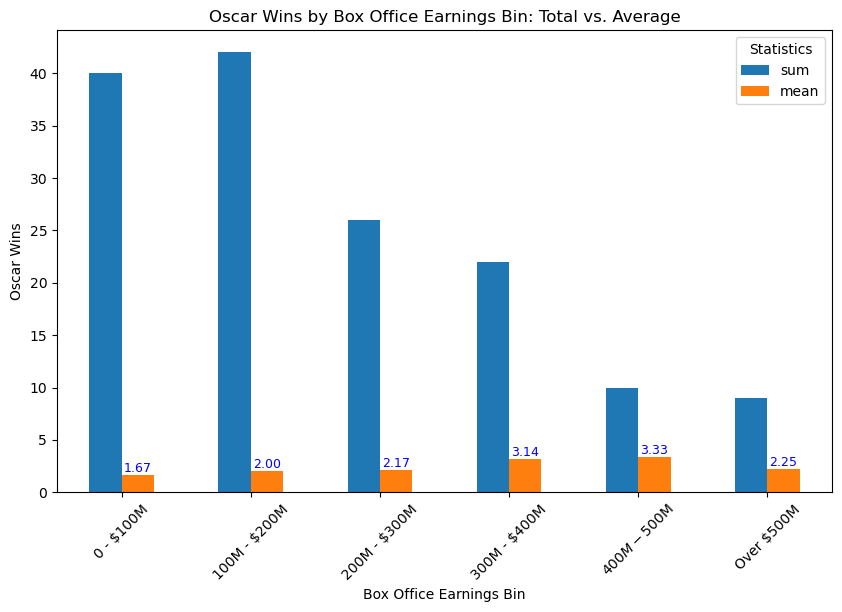

In [18]:
grouped = clean_movie_df2.groupby('Box Office Category')['Oscar Awards'].agg(['sum', 'mean'])
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(kind='bar', ax=ax)  # This plots both sum and mean as different bars

# Adding labels and title
plt.title('Oscar Wins by Box Office Earnings Bin: Total vs. Average')
plt.xlabel('Box Office Earnings Bin')
plt.ylabel('Oscar Wins')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend(title='Statistics')

for i, rect in enumerate(ax.patches[len(ax.patches)//2:]):  # Only the second half of patches which correspond to the 'mean'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, f'{grouped["mean"].iloc[i]:.2f}', 
            ha='center', va='bottom', rotation=0, color='blue', fontsize=9)
    
# Show the plot
plt.show()

/var/folders/hs/gpfk35m163v8nk31_7kfcs640000gn/T/ipykernel_14378/1333527029.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = clean_movie_df2.groupby(['Oscar Nominations', 'Box Office Category']).size().unstack(fill_value=0)


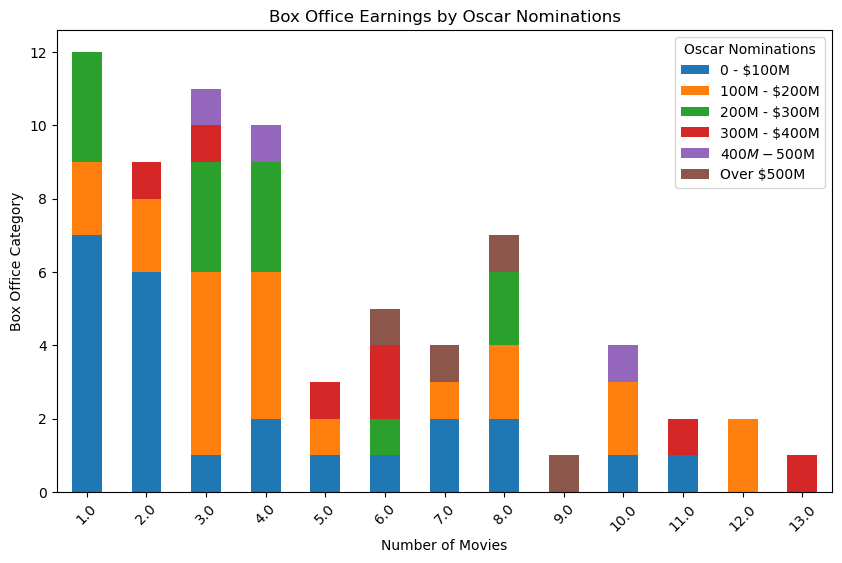

In [19]:
summary_df = clean_movie_df2.groupby(['Oscar Nominations', 'Box Office Category']).size().unstack(fill_value=0)

summary_df.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title('Box Office Earnings by Oscar Nominations')
plt.xlabel('Number of Movies')
plt.ylabel('Box Office Category')
plt.xticks(rotation=45)  
plt.legend(title='Oscar Nominations')
plt.show()

In [24]:
awards_wins_x = clean_movie_df2['Oscar Nominations']
box_office_y = clean_movie_df2['Box Office']

print('NaNs in Oscar Nomination:', awards_wins_x.isna().sum())
print('NaNs in Box Office:', box_office_y.isna().sum())
print('NaNs in Rotten Tomatoes Rating:', awards_wins_x.isna().sum())
print('Infs in Oscar Nomination:', np.isinf(awards_wins_x).sum())
print('Infs in Box Office:', np.isinf(box_office_y).sum())
print('Infs in Rotten Tomatoes Rating:', awards_wins_x.isna().sum())

NaNs in Oscar Nomination: 0
NaNs in Box Office: 0
NaNs in Rotten Tomatoes Rating: 0
Infs in Oscar Nomination: 0
Infs in Box Office: 0
Infs in Rotten Tomatoes Rating: 0


The r-value is: PearsonRResult(statistic=0.21601680923021646, pvalue=0.07040305025299254)


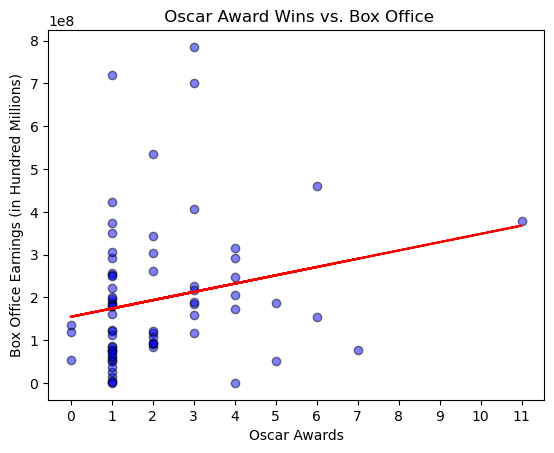

In [28]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Oscar Awards']
box_office_y = clean_movie_df2['Box Office']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title(' Oscar Award Wins vs. Box Office')
plt.xlabel('Oscar Awards')
plt.ylabel('Box Office Earnings (in Hundred Millions)')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.3154616065336829, pvalue=0.007367887727307038)


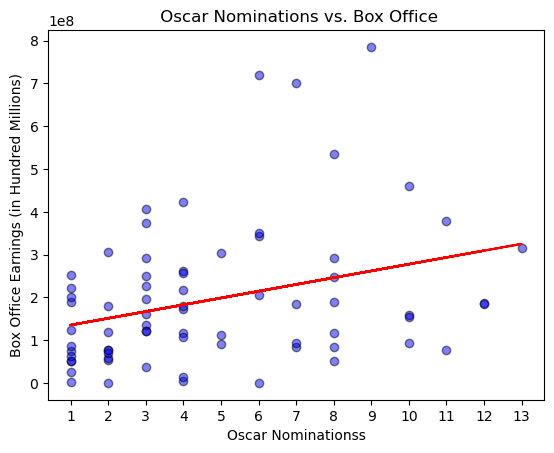

In [29]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Oscar Nominations']
box_office_y = clean_movie_df2['Box Office']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title(' Oscar Nominations vs. Box Office')
plt.xlabel('Oscar Nominationss')
plt.ylabel('Box Office Earnings (in Hundred Millions)')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.41977061662179227, pvalue=0.0002682933192484952)


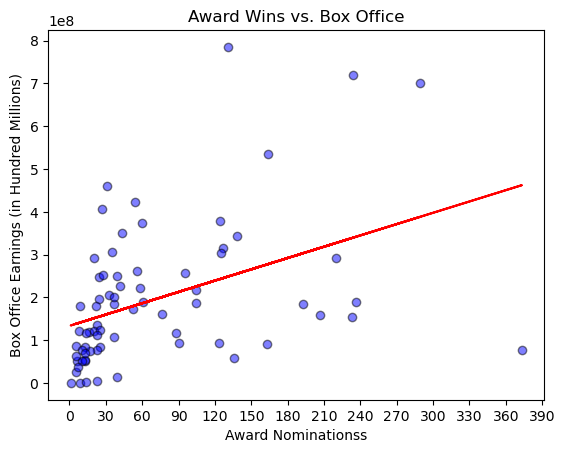

In [31]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Award Nominations']
box_office_y = clean_movie_df2['Box Office']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Wins vs. Box Office')
plt.xlabel('Award Nominationss')
plt.ylabel('Box Office Earnings (in Hundred Millions)')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.3088089498349499, pvalue=0.008786223401461417)


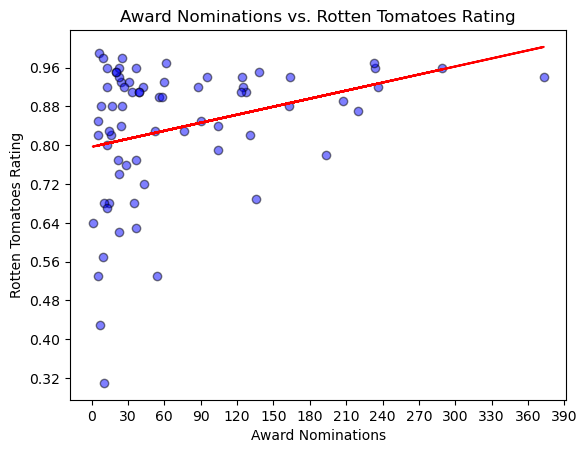

In [43]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Award Nominations']
box_office_y = clean_movie_df2['Rotten Tomatoes Rating']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Nominations vs. Rotten Tomatoes Rating')
plt.xlabel('Award Nominations')
plt.ylabel('Rotten Tomatoes Rating')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.3744040095070815, pvalue=0.0012969920461660008)


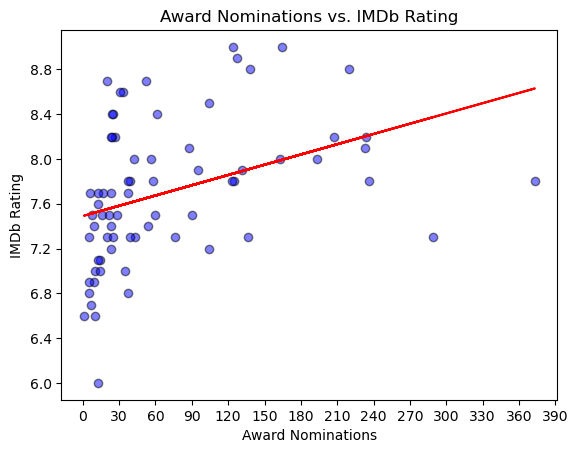

In [41]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Award Nominations']
box_office_y = clean_movie_df2['IMDb Rating']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Nominations vs. IMDb Rating')
plt.xlabel('Award Nominations')
plt.ylabel('IMDb Rating')
plt.grid(False)

print(f'The r-value is: {correlation}')

The r-value is: PearsonRResult(statistic=0.4068862164500489, pvalue=0.0004294448410264778)


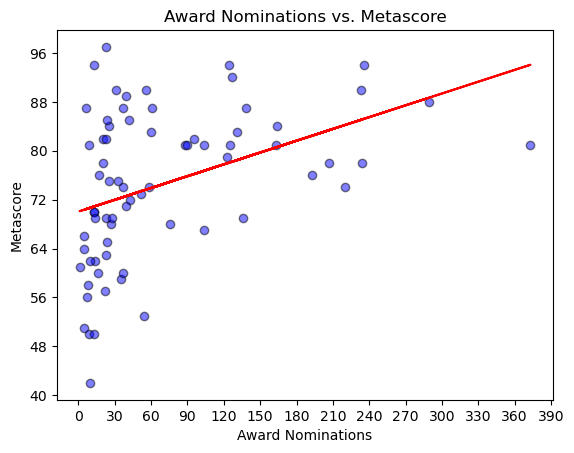

In [42]:
# Define my x and y axis
awards_wins_x = clean_movie_df2['Award Nominations']
box_office_y = clean_movie_df2['Metascore']

# Correlation
correlation = st.pearsonr(awards_wins_x, box_office_y) 

#Linear Regression
(slope, intercept, r_value, p_value, std_err) = linregress(awards_wins_x, box_office_y)
regress_values = awards_wins_x * slope + intercept
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"

plt.scatter(awards_wins_x, box_office_y, 
            marker='o', 
            facecolors='blue', 
            edgecolors='black',
            alpha=0.5)

plt.plot(awards_wins_x, regress_values, "r-")  # Corrected to use regress_values
#plt.annotate(line_eq, xy=(0.05, 0.95), xycoords='axes fraction',
#             fontsize=12, color="red", verticalalignment='top')

ax = plt.gca() 
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))

# Title, labels, and aesthetics
plt.title('Award Nominations vs. Metascore')
plt.xlabel('Award Nominations')
plt.ylabel('Metascore')
plt.grid(False)

print(f'The r-value is: {correlation}')

In [23]:
clean_movie_df2.to_csv('movies_awards_analysis.csv', index=False) 